# DigiCard by ABC Payments Bank
ABC Payments Bank is a mobile-only bank based out of Bengaluru, India. Their primary
business is to give out digital credit cards to eligible users with a credit limit ranging from 1000 to 8000 dollars all over the world. These digital credit cards are issued within an hour after filling up a
form in the Bank’s Mobile App called DigiCard.
This product provides a very good revenue to the banks, however, it’s a challenging task for
them to decide who should they approve for the card and who to reject. You have to help this
bank decide how can they confidently take this decision based on the experience they had in
the past.
Using the attached dataset which contains historical data about bank’s old customers, the
problem has two primary goals:
1. Whom to approve or reject for the credit card?
2. How much credit limit to give if approved?

In [1]:
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import os
data_path = "/content/gdrive/My Drive/"

In [3]:
#import required packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
ABC_data = pd.read_csv(data_path+"simpl_payments_bank_digicard_v1.0.csv")
ABC_data.drop(['address','email','asset_class_cd'], axis=1, inplace = True) # removing irrelevant and missing data columns

In [5]:
ABC_data.head(1000)
ABC_data.shape

(45222, 18)

In [6]:
# check for null values in each attribute
print(ABC_data.isnull().sum())

user_id                    0
gender                     0
date_of_birth              0
workclass                  0
education_level            0
education_num              0
marital_status             0
occupation                 0
relationship               0
capital_gain               0
capital_loss               0
hours_per_week             0
approved                   0
inquiry_purpose_code    1291
institute_type             0
account_type               0
asset_code                82
portfolio_type             6
dtype: int64


In [0]:
# treating null values as a separate inquiry code
# impute a unique value for inquiry_purpose_code attribute
ABC_data['inquiry_purpose_code'].fillna(0 , inplace = True)

In [8]:
ABC_data.isnull().sum()

user_id                  0
gender                   0
date_of_birth            0
workclass                0
education_level          0
education_num            0
marital_status           0
occupation               0
relationship             0
capital_gain             0
capital_loss             0
hours_per_week           0
approved                 0
inquiry_purpose_code     0
institute_type           0
account_type             0
asset_code              82
portfolio_type           6
dtype: int64

In [0]:
# drop null value rows for attributes - asset_code and portfolio_type 
ABC_data.dropna(subset = ['asset_code','portfolio_type'], inplace = True)

In [10]:
ABC_data.isnull().sum()

user_id                 0
gender                  0
date_of_birth           0
workclass               0
education_level         0
education_num           0
marital_status          0
occupation              0
relationship            0
capital_gain            0
capital_loss            0
hours_per_week          0
approved                0
inquiry_purpose_code    0
institute_type          0
account_type            0
asset_code              0
portfolio_type          0
dtype: int64

In [11]:
ABC_data.shape

(45134, 18)

In [0]:
# convert DOB to Year of birth
ABC_data['year_of_birth'] = pd.DatetimeIndex(ABC_data['date_of_birth']).year
ABC_data.drop('date_of_birth', axis = 1, inplace = True)

In [13]:
ABC_data.dtypes

user_id                  object
gender                   object
workclass                object
education_level          object
education_num             int64
marital_status           object
occupation               object
relationship             object
capital_gain              int64
capital_loss              int64
hours_per_week            int64
approved                  int64
inquiry_purpose_code    float64
institute_type           object
account_type              int64
asset_code              float64
portfolio_type           object
year_of_birth             int64
dtype: object

# Correlation Analysis

In [14]:
# Coverting categorical variables into dummy variables
ABC_dummied_data = pd.get_dummies(ABC_data, columns = ['gender','workclass','marital_status','occupation','relationship','institute_type','portfolio_type' ],drop_first=True)
ABC_dummied_data.dtypes

user_id                                   object
education_level                           object
education_num                              int64
capital_gain                               int64
capital_loss                               int64
hours_per_week                             int64
approved                                   int64
inquiry_purpose_code                     float64
account_type                               int64
asset_code                               float64
year_of_birth                              int64
gender_ Male                               uint8
workclass_ Local-gov                       uint8
workclass_ Private                         uint8
workclass_ Self-emp-inc                    uint8
workclass_ Self-emp-not-inc                uint8
workclass_ State-gov                       uint8
workclass_ Without-pay                     uint8
marital_status_ Married-AF-spouse          uint8
marital_status_ Married-civ-spouse         uint8
marital_status_ Marr

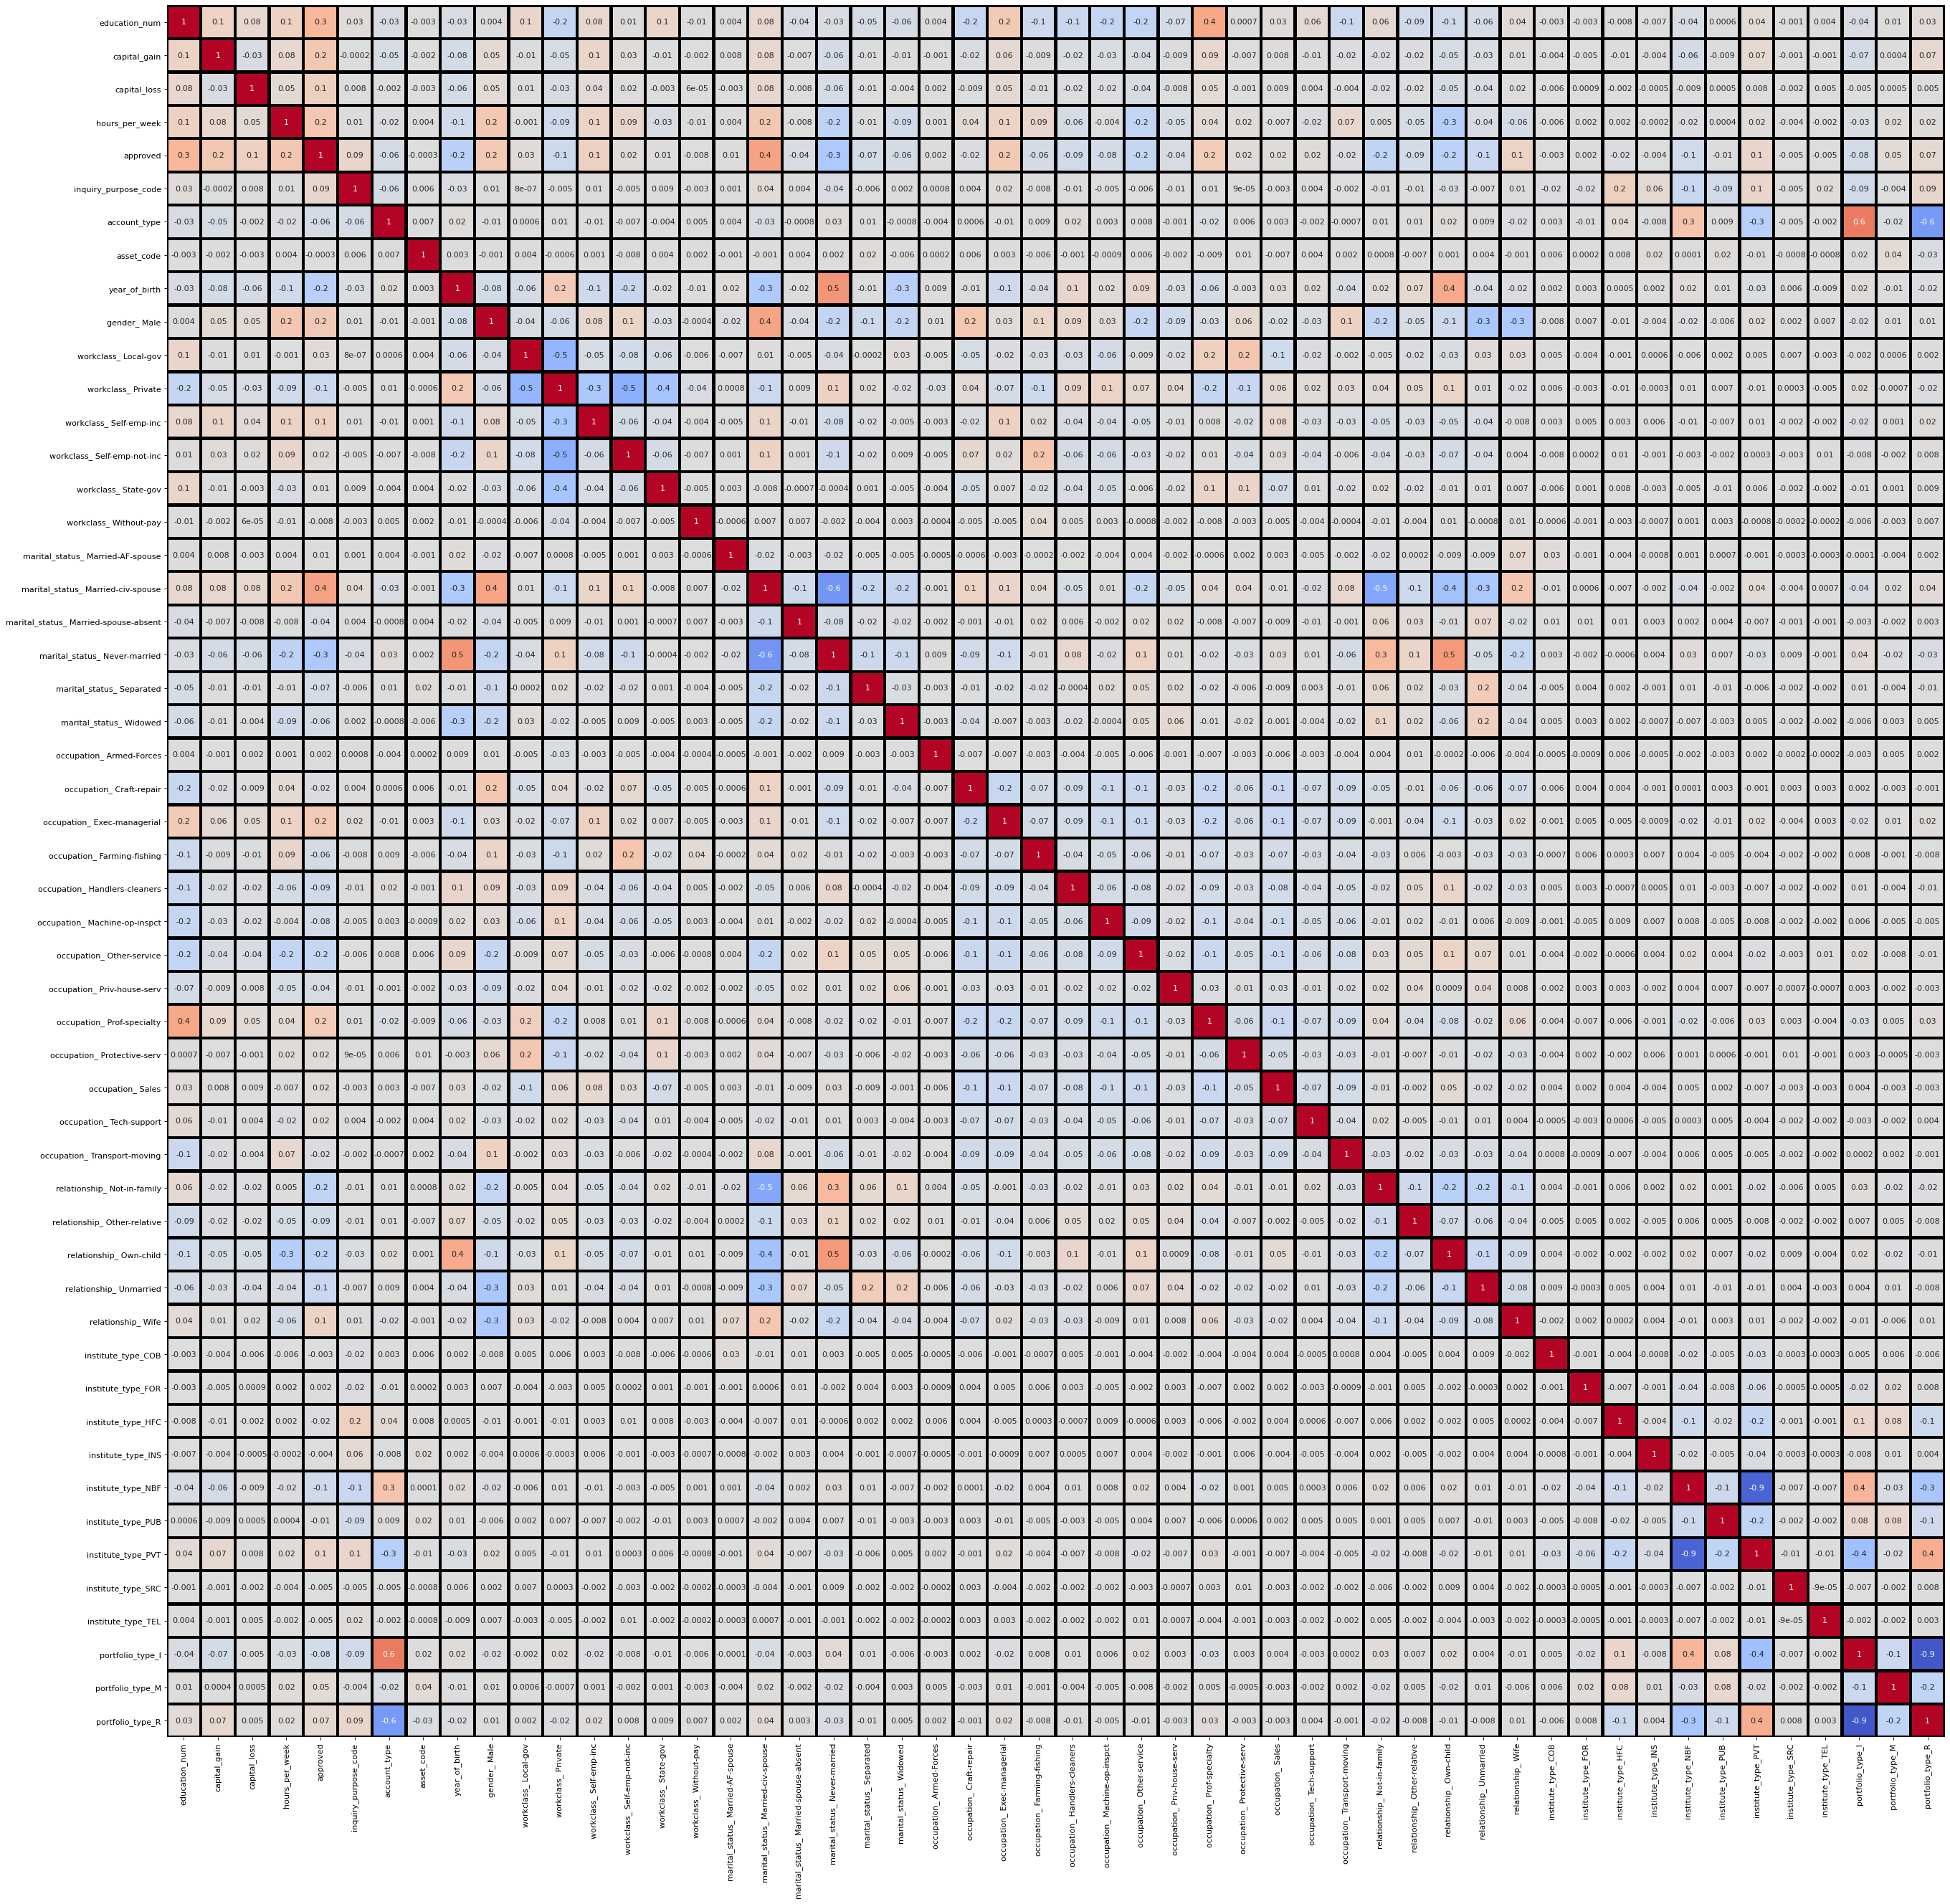

In [15]:
# create heatmap to find correlation between attributes
from matplotlib.pyplot import figure
figure(num=None, figsize=(40, 40), dpi=80, facecolor='w', edgecolor='k')
sns.heatmap(ABC_dummied_data.corr(), annot = True, vmin=-1, vmax=1, center= 0, cbar = False, fmt = '.1g', cmap= 'coolwarm', linewidths=3, linecolor='black')

In [16]:
# Correlation summary
corr = pd.DataFrame(ABC_dummied_data.corr().unstack().sort_values().drop_duplicates(), columns = ['correlation'])
high_pos_corr = corr[(corr['correlation']>0.7)]

high_neg_corr = corr[(corr['correlation']<-0.7)]
print('Highly positive correlation attributes:\n',high_pos_corr,'\n \nHighly negative correlation attributes:\n',high_neg_corr)

Highly positive correlation attributes:
                              correlation
education_num education_num          1.0 
 
Highly negative correlation attributes:
                                        correlation
portfolio_type_I   portfolio_type_R      -0.947733
institute_type_PVT institute_type_NBF    -0.884093


In [17]:
# delete id, education_level and high correlated attributes 
ABC_dummied_data.drop(['user_id','education_level','institute_type_NBF','portfolio_type_R'], axis = 1, inplace = True)
ABC_dummied_data.dtypes

education_num                              int64
capital_gain                               int64
capital_loss                               int64
hours_per_week                             int64
approved                                   int64
inquiry_purpose_code                     float64
account_type                               int64
asset_code                               float64
year_of_birth                              int64
gender_ Male                               uint8
workclass_ Local-gov                       uint8
workclass_ Private                         uint8
workclass_ Self-emp-inc                    uint8
workclass_ Self-emp-not-inc                uint8
workclass_ State-gov                       uint8
workclass_ Without-pay                     uint8
marital_status_ Married-AF-spouse          uint8
marital_status_ Married-civ-spouse         uint8
marital_status_ Married-spouse-absent      uint8
marital_status_ Never-married              uint8
marital_status_ Sepa

In [18]:
# delete Id and repeated variable education_level
ABC_orig_data = ABC_data.drop(['user_id','education_level'], axis = 1)
ABC_orig_data

,gender,workclass,education_num,marital_status,occupation,relationship,capital_gain,capital_loss,hours_per_week,approved,inquiry_purpose_code,institute_type,account_type,asset_code,portfolio_type,year_of_birth
0,Female,Private,7,Never-married,Sales,Unmarried,0,0,17,0,7.0,PVT,5,1.0,R,1987
1,Male,Self-emp-not-inc,10,Married-civ-spouse,Craft-repair,Husband,0,0,48,0,13.0,NBF,5,1.0,R,1970
2,Male,Private,9,Divorced,Sales,Not-in-family,0,0,50,0,13.0,NBF,5,1.0,R,1973
3,Female,Private,7,Never-married,Sales,Own-child,0,0,15,0,13.0,NBF,5,1.0,R,2001
4,Male,Private,10,Married-civ-spouse,Handlers-cleaners,Husband,0,0,50,0,13.0,PVT,47,1.0,I,1986
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45217,Male,Private,15,Married-civ-spouse,Prof-specialty,Husband,99999,0,60,1,7.0,PVT,5,1.0,R,1976
45218,Male,Private,15,Married-spouse-absent,Prof-specialty,Not-in-family,99999,0,40,1,7.0,PVT,5,1.0,R,1977
45219,Male,Self-emp-inc,15,Married-civ-spouse,Prof-specialty,Husband,99999,0,45,1,13.0,NBF,189,1.0,I,1964
45220,Male,Private,13,Married-civ-spouse,Craft-repair,Husband,99999,0,40,1,7.0,PVT,5,1.0,R,1979


# Exploratory Data Analysis (EDA)

Approved EDA

0    33950
1    11184
Name: approved, dtype: int64


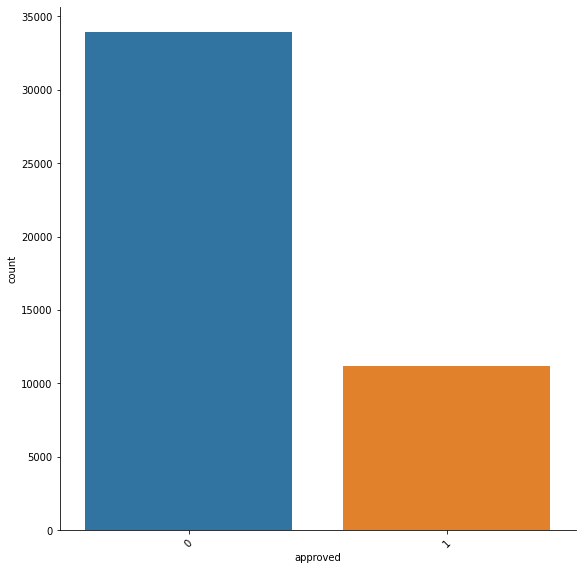

In [19]:
approved_plot = sns.catplot(x="approved",
                data=ABC_orig_data, kind="count",
                height=8);
print(ABC_orig_data['approved'].value_counts())
approved_plot.set_xticklabels(rotation=45)

# not an imbalanced class

Gender EDA

 Male      30465
 Female    14669
Name: gender, dtype: int64


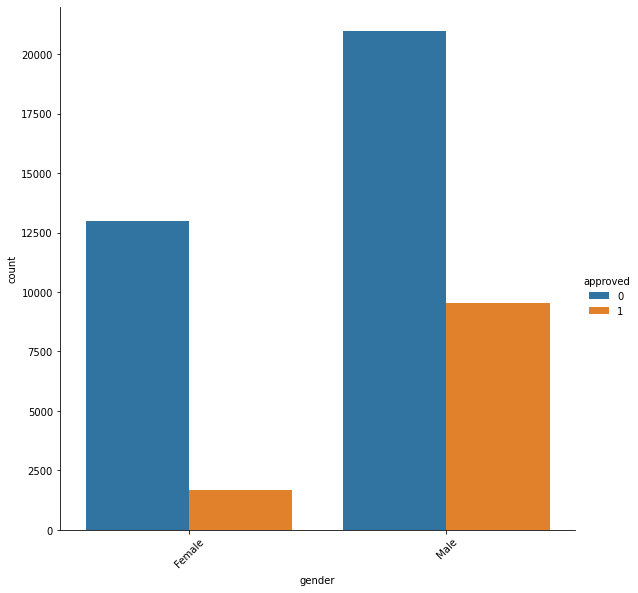

In [20]:
gender_plot = sns.catplot(x="gender", hue="approved",
                data=ABC_orig_data, kind="count",
                height=8);
print(ABC_orig_data['gender'].value_counts())
gender_plot.set_xticklabels(rotation=45)

Workclass EDA

 Private             33247
 Self-emp-not-inc     3784
 Local-gov            3089
 State-gov            1944
 Self-emp-inc         1644
 Federal-gov          1405
 Without-pay            21
Name: workclass, dtype: int64


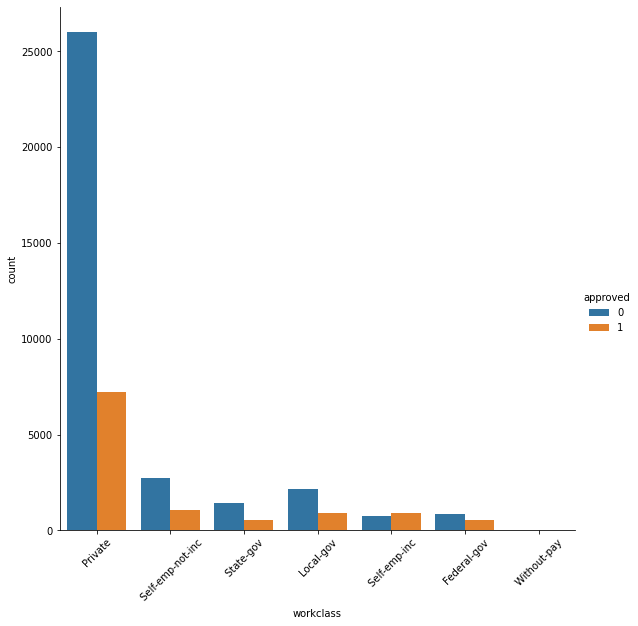

In [21]:
workclass_plot = sns.catplot(x="workclass", hue="approved",
                data=ABC_orig_data, kind="count",
                height=8);
print(ABC_orig_data['workclass'].value_counts())
workclass_plot.set_xticklabels(rotation=45)

In [0]:
# Most of the users belong to the private workclass

Education_level EDA

9     14757
10     9878
13     7553
14     2510
11     1953
7      1617
12     1505
6      1223
4       820
15      782
5       675
8       575
16      543
3       449
2       222
1        72
Name: education_num, dtype: int64


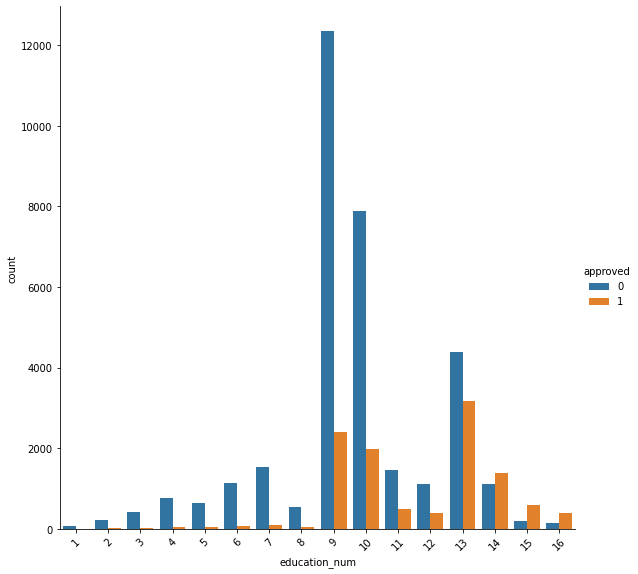

In [23]:
ed_num_plot = sns.catplot(x="education_num", hue="approved",
                data=ABC_orig_data, kind="count",
                height=8);
print(ABC_orig_data['education_num'].value_counts())
ed_num_plot.set_xticklabels(rotation=45)

Marital status EDA

 Married-civ-spouse       21010
 Never-married            14573
 Divorced                  6285
 Separated                 1409
 Widowed                   1274
 Married-spouse-absent      551
 Married-AF-spouse           32
Name: marital_status, dtype: int64


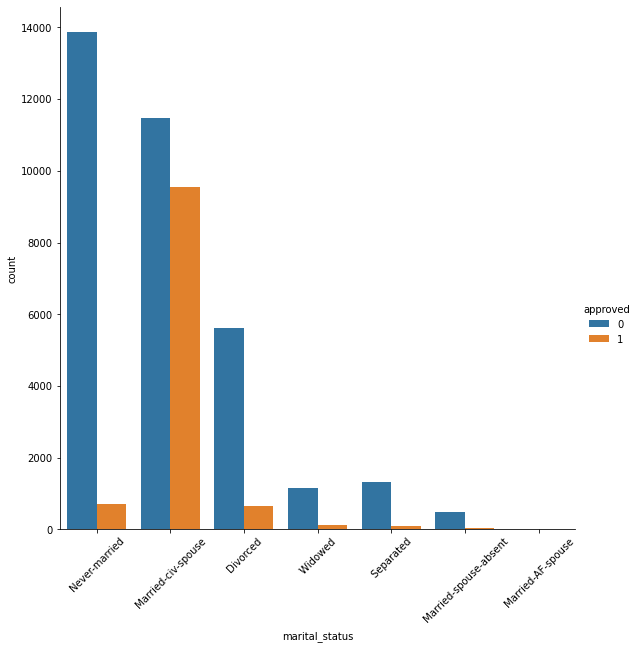

In [24]:
marital_status_plot = sns.catplot(x="marital_status", hue="approved",
                data=ABC_orig_data, kind="count",
                height=8);
print(ABC_orig_data['marital_status'].value_counts())
marital_status_plot.set_xticklabels(rotation=45)

In [0]:
# Majority of the 'Never-maried' people are approved
# Most of the people are Married-civ-spouse

Occupation EDA

 Craft-repair         6010
 Prof-specialty       5995
 Exec-managerial      5975
 Adm-clerical         5531
 Sales                5392
 Other-service        4797
 Machine-op-inspct    2966
 Transport-moving     2311
 Handlers-cleaners    2041
 Farming-fishing      1479
 Tech-support         1417
 Protective-serv       974
 Priv-house-serv       232
 Armed-Forces           14
Name: occupation, dtype: int64


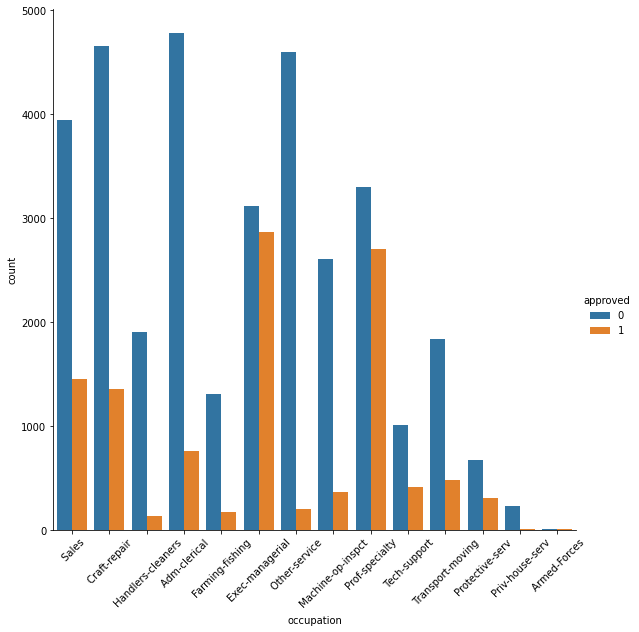

In [26]:
occupation_plot = sns.catplot(x="occupation", hue="approved",
                data=ABC_orig_data, kind="count",
                height=8);
print(ABC_orig_data['occupation'].value_counts())
occupation_plot.set_xticklabels(rotation=45)

Relationship EDA

 Husband           18627
 Not-in-family     11679
 Own-child          6613
 Unmarried          4783
 Wife               2085
 Other-relative     1347
Name: relationship, dtype: int64


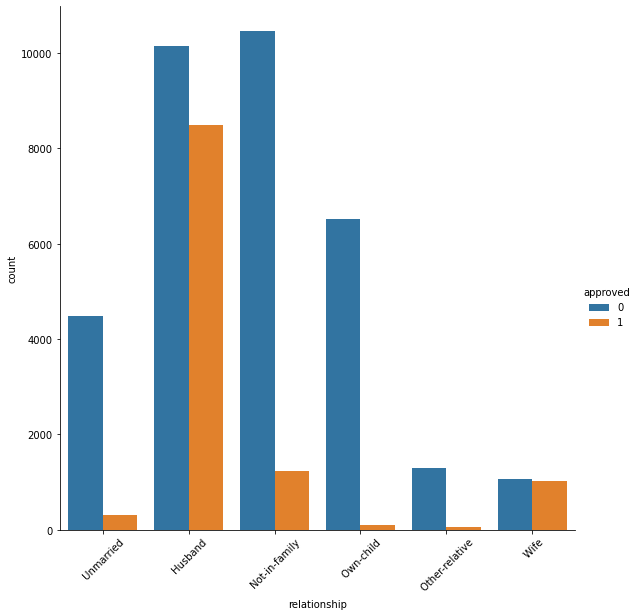

In [27]:
relationship_plot = sns.catplot(x="relationship", hue="approved",
                data=ABC_orig_data, kind="count",
                height=8);
print(ABC_orig_data['relationship'].value_counts())
relationship_plot.set_xticklabels(rotation=45)

In [0]:
# Most individuals are husbands
# Majority people with own-child are not approved

Institute_type EDA

PVT    26624
NBF    15891
PUB     1222
HFC      904
BRO      303
FOR      106
INS       41
COB       35
SRC        4
TEL        4
Name: institute_type, dtype: int64


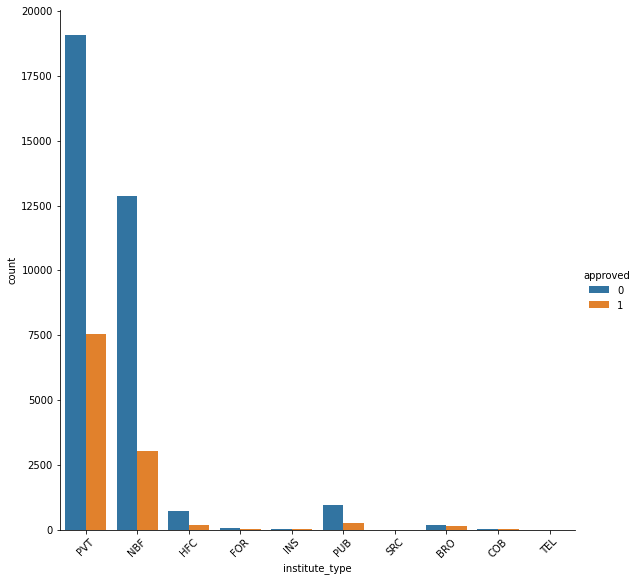

In [29]:

institute_plot = sns.catplot(x="institute_type", hue="approved",
                data=ABC_orig_data, kind="count",
                height=8);
print(ABC_orig_data['institute_type'].value_counts())
institute_plot.set_xticklabels(rotation=45)

Portfolio_type EDA

R    26934
I    17047
M     1138
F       15
Name: portfolio_type, dtype: int64


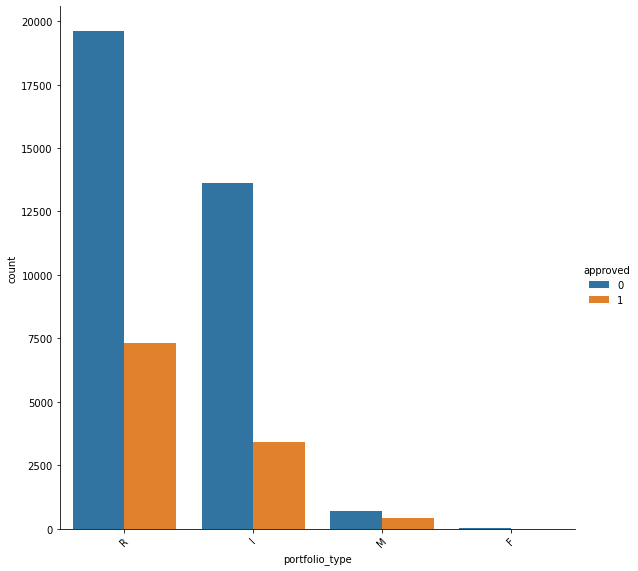

In [30]:
portfolio_plot = sns.catplot(x="portfolio_type", hue="approved",
                data=ABC_orig_data, kind="count",
                height=8);
print(ABC_orig_data['portfolio_type'].value_counts())
portfolio_plot.set_xticklabels(rotation=45)

Capital_gain vs Approved

[    0   114   401   594   914   991  1055  1086  1151  1173  1264  1409
  1424  1455  1471  1506  1639  1731  1797  1831  1848  2009  2036  2050
  2062  2105  2174  2176  2202  2228  2290  2329  2346  2354  2387  2407
  2414  2463  2538  2580  2597  2635  2653  2829  2885  2907  2936  2961
  2964  2977  2993  3103  3137  3273  3325  3411  3418  3432  3456  3464
  3471  3674  3781  3818  3887  3908  3942  4064  4101  4386  4416  4508
  4650  4865  4931  5013  5060  5455  5721  6360  6497  6723  6767  6849
  7443  7896  7978 10566 22040 34095 41310  4687  4787  4934  5178  5556
  6097  6418  6514  7262  7298  7430  7688  8614  9386  9562 10520 10605
 11678 13550 14084 14344 15020 15024 15831 18481 20051 25124 25236 27828
 99999]
int64


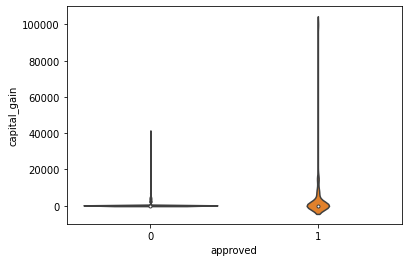

In [31]:
sns.violinplot(x='approved', y='capital_gain', data=ABC_orig_data, scale = 'area')
print(ABC_orig_data['capital_gain'].unique())
print(ABC_orig_data['capital_gain'].dtype)

Year of Birth EDA

[1987 1970 1973 2001 1986 1956 1996 1977 1963 1997 1988 1999 1993 1983
 1968 1981 1992 1982 1976 1969 1995 1975 2002 1946 1990 1964 1978 1980
 1998 1985 1966 1961 2000 1991 1979 1989 1958 1962 1994 1955 1984 1951
 1974 1954 1959 1971 1965 1960 1952 1972 1967 1957 1950 1949 1930 1953
 1948 1945 1947 1939 1942 1938 1943 1940 1935 1944 1932 1934 1941 1936
 1937 1933 1931]
int64


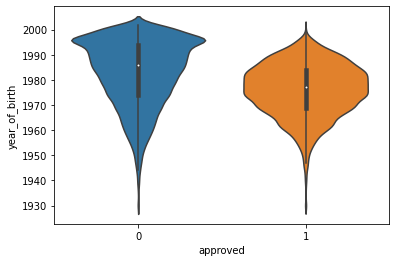

In [32]:
sns.violinplot(x='approved', y='year_of_birth', data=ABC_orig_data, scale = 'area')
print(ABC_orig_data['year_of_birth'].unique())
print(ABC_orig_data['year_of_birth'].dtype)

Capital_loss vs Approved

[   0 1876 1719 1485 1602 1740 1340 1721 2051 1974 1741 1579 1380 2001
 2002 2267 2057 1669 1092 1628 1672 1617 1902 1594 1590 1980 2377 1573
  625 2179 2754 2258 1504 1408  213 1668 1651 1429 1258 2205 2042 2339
 1726 1762 1411  323  880 2467 3683 3900 2129 2238 2603 2206 1648 1944
 2149 1844 1138 1510 3175 3770 2163 1735 1870 1421 2457  653  974 1539
 2352 1816  810  155  419 2080 4356 1887 2415 1977 2174 2824 2392 2444
 1848 2246 1564 2559 2472 2231 2547 3004 1755 1825 2201 2282 1911]
int64


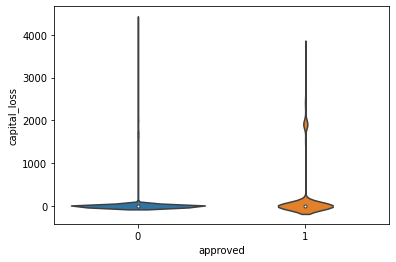

In [33]:
sns.violinplot(x='approved', y='capital_loss', data=ABC_orig_data, scale = 'area')
print(ABC_orig_data['capital_loss'].unique())
print(ABC_orig_data['capital_loss'].dtype)

Hours_per_week vs Approved

[17 48 50 15  8 24 45 40 36 25 55 12  4 52 20 22 60 44 11 42 35 30 10 38
 57  2 46  5 70 37 43 32 33 26 78 18 75 65 16 68 72 96 99 56 54  3 77 23
 28 90 34 80 27 47 66 85  7  9 95 59  6 84 58 64 14 49 91 53 21 51 39  1
 92 31 62 41 98 81 76 19 74 13 63 29 86 67 88 73 79 97 82 87 89 94 61 69]
int64


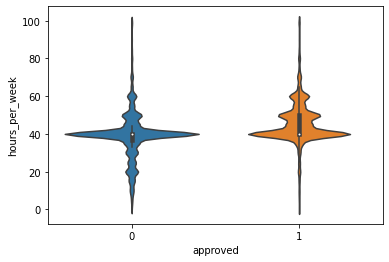

In [34]:
sns.violinplot(x='approved', y='hours_per_week', data=ABC_orig_data, scale = 'area')
print(ABC_orig_data['hours_per_week'].unique())
print(ABC_orig_data['hours_per_week'].dtype)

Inquiry_purpose_code vs Approved

[ 7. 13. 99. 14. 10. 16.  2.  0.  1.  6.  5. 11.  8.  4.  3.  9. 12. 18.
 17.]
float64


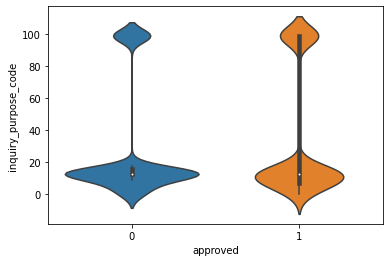

In [35]:
sns.violinplot(x='approved', y='inquiry_purpose_code', data=ABC_orig_data, scale = 'area')
print(ABC_orig_data['inquiry_purpose_code'].unique())
print(ABC_orig_data['inquiry_purpose_code'].dtype)

Inquiry_purpose_code vs Approved

[ 1.  4.  2. 19.]
float64


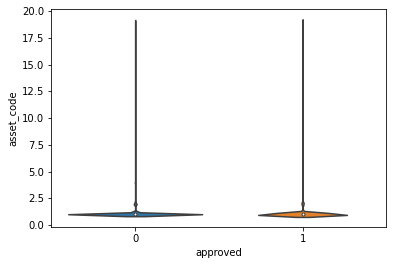

In [36]:
sns.violinplot(x='approved', y='asset_code', data=ABC_orig_data, scale = 'area')
print(ABC_orig_data['asset_code'].unique())
print(ABC_orig_data['asset_code'].dtype)

# Building model

In [0]:
import sklearn
from sklearn import linear_model
from sklearn.model_selection import train_test_split

Splitting original data into train and test dataset

In [0]:
ABC_indep = ABC_orig_data.drop(['approved'],axis = 1)
ABC_dep = ABC_orig_data['approved']

In [0]:
Xorig_train, Xorig_test, yorig_train, yorig_test = train_test_split(ABC_indep, ABC_dep, test_size=0.3, random_state=0)

In [40]:
Xorig_train.shape, yorig_train.shape

((31593, 15), (31593,))

In [41]:
Xorig_test.shape, yorig_test.shape

((13541, 15), (13541,))

Splitting dummied data into train and test datasets

In [0]:
ABC_dummied_indep = ABC_dummied_data.drop(['approved'],axis = 1)
ABC_dummied_dep = ABC_dummied_data['approved']

In [0]:
Xdummied_train, Xdummied_test, ydummied_train, ydummied_test = train_test_split(ABC_dummied_indep, ABC_dummied_dep, test_size=0.3, random_state=0)

In [44]:
Xdummied_train.shape, ydummied_train.shape

((31593, 49), (31593,))

In [45]:
Xdummied_test.shape, ydummied_test.shape

((13541, 49), (13541,))

# Solution - Part 1

Machine Learning modelling

In [0]:
from sklearn.linear_model import LogisticRegressionCV
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.linear_model import Perceptron
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import recall_score

y_true = np.array(ydummied_test)

Logistic regression

In [47]:
# Fitting the Logistic Regression model to dummied dataset
logR_clf = LogisticRegressionCV(cv=8, random_state=0,n_jobs=-1)
logR_clf.fit(Xdummied_train, ydummied_train)

LogisticRegressionCV(Cs=10, class_weight=None, cv=8, dual=False,
                     fit_intercept=True, intercept_scaling=1.0, l1_ratios=None,
                     max_iter=100, multi_class='auto', n_jobs=-1, penalty='l2',
                     random_state=0, refit=True, scoring=None, solver='lbfgs',
                     tol=0.0001, verbose=0)

In [48]:
# Making predictons based on the fitted model
y_logR_predict = logR_clf.predict(Xdummied_test)
y_logR_proba = logR_clf.predict_proba(Xdummied_test)
print(y_logR_predict)
print(ydummied_test)

[0 0 0 ... 0 0 0]
84       0
37083    1
25482    0
29889    0
30055    0
        ..
43493    1
11656    0
24851    0
8337     0
14079    0
Name: approved, Length: 13541, dtype: int64


In [49]:
# Probabilities for test class prediction
y_logR_proba = pd.DataFrame(logR_clf.predict_proba(Xdummied_test), columns = ['Class 1 Prob', 'Class 0 Prob'])
print(y_logR_proba)
print(y_logR_proba.shape)

       Class 1 Prob  Class 0 Prob
0          0.853615      0.146385
1          0.902802      0.097198
2          0.693710      0.306290
3          0.993007      0.006993
4          0.999161      0.000839
...             ...           ...
13536      0.086048      0.913952
13537      0.757792      0.242208
13538      0.788587      0.211413
13539      0.935602      0.064398
13540      0.995996      0.004004

[13541 rows x 2 columns]
(13541, 2)


In [50]:
# Calculating final applied probability
# Set non-approved probabilities to 0 and the rest to Class 1 probabilities.
y_logR_proba['approvedLR_prob'] = np.where(y_logR_proba['Class 1 Prob']>y_logR_proba['Class 0 Prob'], y_logR_proba['Class 1 Prob'],0)
print(y_logR_proba)

       Class 1 Prob  Class 0 Prob  approvedLR_prob
0          0.853615      0.146385         0.853615
1          0.902802      0.097198         0.902802
2          0.693710      0.306290         0.693710
3          0.993007      0.006993         0.993007
4          0.999161      0.000839         0.999161
...             ...           ...              ...
13536      0.086048      0.913952         0.000000
13537      0.757792      0.242208         0.757792
13538      0.788587      0.211413         0.788587
13539      0.935602      0.064398         0.935602
13540      0.995996      0.004004         0.995996

[13541 rows x 3 columns]


In [51]:
confusion_matrix(y_true, y_logR_predict)
print('Model prediction accuracy is \n:', accuracy_score(y_true, y_logR_predict))

Model prediction accuracy is 
: 0.8472047854663615


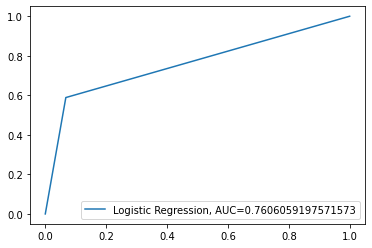

In [52]:
# Plot AUC curve for Logistic regression model
fpr, tpr, threshold = metrics.roc_curve(y_true,  y_logR_predict)
auc = metrics.roc_auc_score(ydummied_test, y_logR_predict)
plt.plot(fpr,tpr,label="Logistic Regression, AUC="+str(auc))
plt.legend(loc=4)
plt.show();

Single Perceptron

In [53]:
Perceptron_clf = Perceptron(random_state=0,n_jobs=-1)
Perceptron_clf.fit(Xdummied_train, ydummied_train)

Perceptron(alpha=0.0001, class_weight=None, early_stopping=False, eta0=1.0,
           fit_intercept=True, max_iter=1000, n_iter_no_change=5, n_jobs=-1,
           penalty=None, random_state=0, shuffle=True, tol=0.001,
           validation_fraction=0.1, verbose=0, warm_start=False)

In [54]:
y_Perceptron_predict = Perceptron_clf.predict(Xdummied_test)
print(y_Perceptron_predict)

[0 0 1 ... 0 0 0]


In [55]:
confusion_matrix(y_true, y_Perceptron_predict)
accuracy_score(y_true, y_Perceptron_predict)

0.7514954582379441

In [0]:
# Not a linearly separable classification problem as accuracy is pretty low

Random Forest Classifier (dummied data)

In [57]:
RF_clf = RandomForestClassifier(random_state=0,n_jobs=-1)
RF_clf.fit(Xdummied_train, ydummied_train)
col_names = Xdummied_train.columns
rank = RF_clf.feature_importances_
features_dict = dict(zip(np.argsort(rank),col_names))
print(features_dict)  # Ranking the importance of features

{45: 'education_num', 46: 'capital_gain', 14: 'capital_loss', 21: 'hours_per_week', 28: 'inquiry_purpose_code', 39: 'account_type', 42: 'asset_code', 15: 'year_of_birth', 40: 'gender_ Male', 17: 'workclass_ Local-gov', 20: 'workclass_ Private', 19: 'workclass_ Self-emp-inc', 35: 'workclass_ Self-emp-not-inc', 41: 'workclass_ State-gov', 43: 'workclass_ Without-pay', 30: 'marital_status_ Married-AF-spouse', 25: 'marital_status_ Married-civ-spouse', 48: 'marital_status_ Married-spouse-absent', 26: 'marital_status_ Never-married', 6: 'marital_status_ Separated', 24: 'marital_status_ Widowed', 13: 'occupation_ Armed-Forces', 32: 'occupation_ Craft-repair', 33: 'occupation_ Exec-managerial', 11: 'occupation_ Farming-fishing', 9: 'occupation_ Handlers-cleaners', 37: 'occupation_ Machine-op-inspct', 36: 'occupation_ Other-service', 22: 'occupation_ Priv-house-serv', 27: 'occupation_ Prof-specialty', 38: 'occupation_ Protective-serv', 31: 'occupation_ Sales', 12: 'occupation_ Tech-support', 47

In [58]:
# Predicting the classes using RF model
y_RF_predict = RF_clf.predict(Xdummied_test)
print(y_RF_predict)

[0 0 0 ... 0 0 0]


In [59]:
print(confusion_matrix(y_true, y_RF_predict))
print('Random Forest model accurcy is:n',accuracy_score(y_true, y_RF_predict))

[[9438  743]
 [1174 2186]]
Random Forest model accurcy is:n 0.8584299534746326


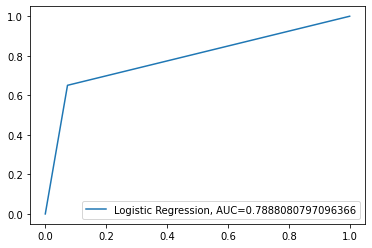

In [60]:
fpr, tpr, threshold = metrics.roc_curve(y_true,  y_RF_predict)
auc = metrics.roc_auc_score(ydummied_test, y_RF_predict)
plt.plot(fpr,tpr,label="Logistic Regression, AUC="+str(auc))
plt.legend(loc=4)
plt.show();

In [61]:
# recall score
recall_score(ydummied_test, y_RF_predict, average='macro')

0.7888080797096366

In [62]:
y_RF_proba = pd.DataFrame(RF_clf.predict_proba(Xdummied_test), columns = ['Class 1 prob','Class 0 prob']) 
print(y_RF_proba)

       Class 1 prob  Class 0 prob
0              0.86          0.14
1              0.81          0.19
2              0.83          0.17
3              1.00          0.00
4              1.00          0.00
...             ...           ...
13536          0.06          0.94
13537          0.83          0.17
13538          0.72          0.28
13539          0.96          0.04
13540          1.00          0.00

[13541 rows x 2 columns]


In [63]:
# find the approved probabilities with RF classifier
# Set non-approved probabilities to 0 and rest to Class 1 probabilities.
y_RF_proba['approvedRF_prob'] = np.where(y_RF_proba['Class 1 prob']>y_RF_proba['Class 0 prob'], y_RF_proba['Class 1 prob'], 0)
y_RF_proba

,Class 1 prob,Class 0 prob,approvedRF_prob
0,0.86,0.14,0.86
1,0.81,0.19,0.81
2,0.83,0.17,0.83
3,1.00,0.00,1.00
4,1.00,0.00,1.00
...,...,...,...
13536,0.06,0.94,0.00
13537,0.83,0.17,0.83
13538,0.72,0.28,0.72
13539,0.96,0.04,0.96


In [0]:
# overall aim of the model should be to improve true positive prediction accuracy i.e. Recall score

Solution - Part B

In [65]:
print('Probability of approved individuals obtained through Logitic Regression model:\n', y_logR_proba['approvedLR_prob'])

Probability of approved individuals obtained through Logitic Regression model:
 0        0.853615
1        0.902802
2        0.693710
3        0.993007
4        0.999161
           ...   
13536    0.000000
13537    0.757792
13538    0.788587
13539    0.935602
13540    0.995996
Name: approvedLR_prob, Length: 13541, dtype: float64


In [66]:
print('Probability of approved individuals obtained through Random Forest model:\n', y_RF_proba['approvedRF_prob'])

Probability of approved individuals obtained through Random Forest model:
 0        0.86
1        0.81
2        0.83
3        1.00
4        1.00
         ... 
13536    0.00
13537    0.83
13538    0.72
13539    0.96
13540    1.00
Name: approvedRF_prob, Length: 13541, dtype: float64


In [67]:
credit_limit_min = 1000
credit_limit_max = 8000
print('Credit Limit range : $', credit_limit_min , '-', credit_limit_max)

Credit Limit range : $ 1000 - 8000


In [68]:
# Credit Limit based on Logistic Regression model
LR_credit_limit =  y_logR_proba['approvedLR_prob']*credit_limit_max
print('Individual Credit Limit (based on Logistic Regression model):\n', LR_credit_limit)

Individual Credit Limit (based on Logistic Regression model):
 0        6828.923960
1        7222.418590
2        5549.679519
3        7944.059879
4        7993.286294
            ...     
13536       0.000000
13537    6062.336875
13538    6308.692576
13539    7484.813547
13540    7967.967050
Name: approvedLR_prob, Length: 13541, dtype: float64


In [69]:
# Credit Limit based on Random Forest Classifier model
RF_credit_limit =  y_RF_proba['approvedRF_prob']*credit_limit_max
print('Individual Credit Limit (based on Logistic Regression model):\n', RF_credit_limit)

Individual Credit Limit (based on Logistic Regression model):
 0        6880.0
1        6480.0
2        6640.0
3        8000.0
4        8000.0
          ...  
13536       0.0
13537    6640.0
13538    5760.0
13539    7680.0
13540    8000.0
Name: approvedRF_prob, Length: 13541, dtype: float64


In [0]:
# Thus all the given project task goals were covered and used Random Forest Classifier which gave good recall score to achieve the stated goals.